# Limpieza y Preparación de Datos - Saber 11

Este notebook contiene el proceso completo de limpieza y preparación de datos de las pruebas Saber 11 para análisis predictivo. El objetivo es transformar los datos crudos consolidados en un dataset limpio y estructurado, listo para ser utilizado en modelos de machine learning.

## Objetivos de la Limpieza

Implementé un pipeline de limpieza comprehensivo que incluye:
- Eliminación de duplicados y registros inconsistentes
- Tratamiento estratégico de valores nulos
- Estandarización de formatos y categorías
- Propagación de información por código de establecimiento
- Eliminación de columnas redundantes o con exceso de valores faltantes
- Normalización de valores categóricos

El resultado final es un dataset optimizado que preserva la calidad de información necesaria para el modelado predictivo.

In [10]:
# Inicialización de Spark y carga del dataset consolidado
from pyspark.sql import SparkSession, functions as F, types as T
import os, pathlib

# Creación de la sesión Spark para procesamiento distribuido
spark = SparkSession.builder.appName('Limpieza_Saber11').getOrCreate()

# Definición de rutas candidatas para el archivo CSV consolidado
# Utilizo múltiples rutas para flexibilidad en diferentes entornos
csv_candidates = []
if 'csv_path' in globals() and isinstance(globals()['csv_path'], str):
    csv_candidates.append(globals()['csv_path'])
csv_candidates.extend(['datos/municipios_bucaramanga_santamarta.csv', 'municipios_bucaramanga_santamarta.csv'])

# Búsqueda del archivo CSV en las rutas candidatas
chosen = None
for p in csv_candidates:
    ap = str(pathlib.Path(p).resolve())
    if os.path.exists(ap):
        chosen = ap
        break

if not chosen:
    raise FileNotFoundError('No se encontró municipios_bucaramanga_santamarta.csv. Verificar ubicación del archivo en datos/ o raíz del proyecto.')

# Carga del CSV con inferencia automática de esquema
sdf_saber = (spark.read.option('header', True).option('inferSchema', True).csv(chosen))

# Normalización del campo municipio para garantizar consistencia
# Elimino espacios irregulares y convierto a mayúsculas
sdf_saber = sdf_saber.withColumn(
    'municipio',
    F.upper(F.regexp_replace(F.regexp_replace(F.trim(F.col('municipio')), '[\u00A0\u2007\u202F]', ' '), '\\s+', ' '))
)

# Extracción de componentes temporales del campo periodo
# El formato es YYYYP donde YYYY=año y P=periodo (1 o 2)
sdf_saber = sdf_saber.withColumn('periodo', F.col('periodo').cast('string'))
sdf_saber = sdf_saber.withColumn('anio', F.col('periodo').substr(1, 4).cast('int'))
sdf_saber = sdf_saber.withColumn('p', F.col('periodo').substr(5, 1).cast('int'))

print(f'Carga completada: {sdf_saber.count():,} registros iniciales')

Carga completada: 218,223 registros iniciales


## 1. Limpieza Básica: Duplicados y Columnas Vacías

Implemento la primera fase de limpieza enfocada en eliminar registros duplicados y columnas sin información útil.

In [11]:
# ============================================================================
# CONFIGURACIÓN DE LIMPIEZA DE DATOS - SABER 11
# ============================================================================
# NOTA: Si se ejecuta en cluster Apache Spark, asegurarse de que el SparkSession
# esté configurado correctamente (ver documentación en notebook de Análisis o README).
#
# Para cluster, usar rutas HDFS en lugar de rutas locales:
# - Local: 'datos/saber_11_completo.csv'
# - HDFS: 'hdfs://namenode:9000/user/nombre_usuario/datos/saber_11_completo.csv'
# ============================================================================

print('LIMPIEZA BÁSICA DE DATOS')
print('='*60)

from pyspark.sql import functions as F
import os, pathlib

# Configuración de parámetros de limpieza
# Estas banderas controlan qué procesos de limpieza se ejecutan
DROP_OUTLIERS = False        # No elimino outliers en esta fase
DROP_ZERO_GLOBAL = False     # Mantengo registros con puntaje global 0
DROP_DUPLICATES = True       # Elimino duplicados basados en clave
USE_CLEAN_FOR_ANALYSIS = True

# Dataset de partida
base = sdf_saber

# Conversión de tipos para garantizar consistencia en operaciones numéricas
base = (base
        .withColumn('punt_global', F.col('punt_global').cast('double'))
        .withColumn('periodo', F.col('periodo').cast('string'))
        .withColumn('anio', F.col('anio').cast('int'))
        .withColumn('p', F.col('p').cast('int'))
       )

# PASO 1: Eliminación de registros duplicados
print('\nPaso 1: Eliminación de duplicados')
if DROP_DUPLICATES:
    # Identifico la clave primaria según columnas disponibles
    if all(c in base.columns for c in ['periodo', 'estu_consecutivo']):
        key = ['periodo', 'estu_consecutivo']
    elif all(c in base.columns for c in ['periodo', 'estu_estudiante']):
        key = ['periodo', 'estu_estudiante']
    else:
        key = []

    if key:
        before = base.count()
        base = base.dropDuplicates(key)
        after = base.count()
        print(f'   Duplicados eliminados usando clave {key}: {before-after:,}')
        print(f'   Registros restantes: {after:,}')
    else:
        print('   Advertencia: No se encontró clave única para deduplicación')
        print('   Se omite para evitar eliminación incorrecta de registros válidos')
else:
    print('   Deduplicación desactivada')

# PASO 2: Eliminación de columnas completamente vacías
print('\nPaso 2: Eliminación de columnas sin datos')
# Cuento registros no nulos por columna
counts_row = base.agg(*[F.count(F.col(c)).alias(c) for c in base.columns]).collect()[0].asDict()
cols_drop = [c for c, cnt in counts_row.items() if (cnt is None) or (int(cnt) == 0)]

if cols_drop:
    base = base.select(*[c for c in base.columns if c not in cols_drop])
    print(f'   Columnas eliminadas (100% nulos): {len(cols_drop)}')
else:
    print('   No se encontraron columnas completamente vacías')

print('\nNota: Los outliers y registros con puntaje global 0 se mantienen para análisis posterior')

# Almacenamiento en cache del dataset limpio
sdf_clean = base.cache()
print(f'\nResultado de limpieza básica:')
print(f'   Registros finales: {sdf_clean.count():,}')
print(f'   Columnas finales: {len(sdf_clean.columns)}')

# Actualizo la variable principal del dataset
sdf_saber = sdf_clean
print('\nDataset activo actualizado con datos limpios')

LIMPIEZA BÁSICA DE DATOS

Paso 1: Eliminación de duplicados
   Duplicados eliminados usando clave ['periodo', 'estu_consecutivo']: 0
   Registros restantes: 218,223

Paso 2: Eliminación de columnas sin datos
   Duplicados eliminados usando clave ['periodo', 'estu_consecutivo']: 0
   Registros restantes: 218,223

Paso 2: Eliminación de columnas sin datos
   Columnas eliminadas (100% nulos): 91

Nota: Los outliers y registros con puntaje global 0 se mantienen para análisis posterior

Resultado de limpieza básica:
   Columnas eliminadas (100% nulos): 91

Nota: Los outliers y registros con puntaje global 0 se mantienen para análisis posterior

Resultado de limpieza básica:
   Registros finales: 218,223
   Columnas finales: 90

Dataset activo actualizado con datos limpios
   Registros finales: 218,223
   Columnas finales: 90

Dataset activo actualizado con datos limpios


## 2. Limpieza Avanzada: Tratamiento de Valores Nulos y Estandarización

Implemento estrategias específicas para el tratamiento de valores nulos, incluyendo propagación de información por código de establecimiento y normalización de categorías.

In [12]:
from pyspark.sql import functions as F
from pyspark.sql import Window
import os

print('LIMPIEZA AVANZADA Y TRATAMIENTO DE NULOS')
print('='*60)

# Diccionario para rastrear métricas de limpieza
metricas_limpieza = {
    'registros_iniciales': 0,
    'columnas_iniciales': 0,
    'duplicados_eliminados': 0,
    'columnas_100_nulos': 0,
    'columnas_con_codigos': 0,
    'columnas_high_nulls': 0,
    'filas_nulos_criticos': 0,
    'columnas_irrelevantes': 0,
    'registros_finales': 0,
    'columnas_finales': 0
}

# Punto de partida para la limpieza avanzada
sdf_prep = sdf_saber
metricas_limpieza['registros_iniciales'] = sdf_prep.count()
metricas_limpieza['columnas_iniciales'] = len(sdf_prep.columns)

print(f'\n📊 Estado inicial:')
print(f'   Registros: {metricas_limpieza["registros_iniciales"]:,}')
print(f'   Columnas: {metricas_limpieza["columnas_iniciales"]}')

# ETAPA 1: Normalización de valores vacíos a NULL
print('\nEtapa 1: Normalización de strings vacíos a NULL')
# Convierto strings que solo contienen espacios en nulos explícitos
for c in sdf_prep.columns:
    if dict(sdf_prep.dtypes)[c] == 'string':
        sdf_prep = sdf_prep.withColumn(c, F.when(F.trim(F.col(c)) == '', None).otherwise(F.col(c)))
print('   Normalización completada para todas las columnas de texto')

# ETAPA 2: Propagación de información por código de establecimiento
print('\nEtapa 2: Propagación de datos por código de establecimiento')
# Para variables del colegio, propago información cuando falta
# usando el código DANE como clave de agrupación
cols_to_propagate = [
    'cole_nombre_establecimiento', 'cole_barrio', 'cole_jornada', 'cole_naturaleza',
    'cole_genero', 'cole_caracter', 'cole_area_ubicacion', 'cole_nombre_sede'
]

if 'cole_cod_dane_establecimiento' in sdf_prep.columns:
    w = Window.partitionBy('cole_cod_dane_establecimiento')
    propagated_count = 0
    
    for c in cols_to_propagate:
        if c in sdf_prep.columns:
            # Utilizo la primera ocurrencia no nula dentro del mismo establecimiento
            sdf_prep = sdf_prep.withColumn(
                c,
                F.coalesce(
                    F.col(c),
                    F.first(F.col(c), ignorenulls=True).over(w)
                )
            )
            propagated_count += 1
    
    print(f'   Propagación aplicada a {propagated_count} columnas')
else:
    print('   Advertencia: Columna de código DANE no disponible')
    print('   Se omite propagación por establecimiento')

# ETAPA 3: Relleno con valores por defecto para variables del colegio
print('\nEtapa 3: Relleno de valores por defecto')
fills_default = {
    'cole_barrio': 'NO_INFO',
    'cole_jornada': 'NO_INFO',
    'cole_naturaleza': 'NO_INFO',
    'cole_genero': 'NO_INFO',
    'cole_caracter': 'NO_INFO',
    'cole_area_ubicacion': 'NO_INFO'
}

applied_fills = 0
for c, v in fills_default.items():
    if c in sdf_prep.columns:
        sdf_prep = sdf_prep.fillna({c: v})
        applied_fills += 1

print(f'   Valores por defecto aplicados a {applied_fills} columnas')

# ETAPA 4: Tratamiento de variables específicas del estudiante
print('\nEtapa 4: Normalización de variables del estudiante')

# Variable género del estudiante
if 'estu_genero' in sdf_prep.columns:
    null_before = sdf_prep.filter(F.col('estu_genero').isNull()).count()
    sdf_prep = sdf_prep.withColumn(
        'estu_genero', 
        F.when(F.col('estu_genero').isNull(), F.lit('Ninguno')).otherwise(F.col('estu_genero'))
    )
    null_after = sdf_prep.filter(F.col('estu_genero').isNull()).count()
    print(f'   estu_genero: {null_before:,} nulos convertidos a "Ninguno"')

# Variable agregado
if 'estu_agregado' in sdf_prep.columns:
    sdf_prep = sdf_prep.withColumn(
        'estu_agregado',
        F.when(F.col('estu_agregado').isNull() | (F.trim(F.col('estu_agregado')) == ''), F.lit('N'))
        .otherwise(F.col('estu_agregado'))
    )
    print('   estu_agregado: valores vacíos/nulos convertidos a "N"')

# ETAPA 5: Eliminación de columnas con códigos internos
print('\nEtapa 5: Eliminación de columnas con códigos')
# Elimino columnas que contienen 'cod' ya que son identificadores internos
cols_drop = [c for c in sdf_prep.columns if 'cod' in c.lower()]
if cols_drop:
    sdf_prep = sdf_prep.drop(*cols_drop)
    metricas_limpieza['columnas_con_codigos'] = len(cols_drop)
    print(f'   Columnas eliminadas: {len(cols_drop)}')
else:
    print('   No se encontraron columnas con códigos para eliminar')

# ETAPA 6: Eliminación de columnas con exceso de nulos (>40%)
print('\nEtapa 6: Eliminación de columnas con más del 40% de nulos')
TOTAL = sdf_prep.count()
non_null_row = sdf_prep.agg(*[F.count(F.col(c)).alias(c) for c in sdf_prep.columns]).collect()[0].asDict()
cols_over_40_null = []

for c in sdf_prep.columns:
    nn = int(non_null_row.get(c, 0) or 0)
    nuls = TOTAL - nn
    pct = (nuls / TOTAL) if TOTAL else 0.0
    if pct > 0.40:
        cols_over_40_null.append(c)

if cols_over_40_null:
    sdf_prep = sdf_prep.select(*[c for c in sdf_prep.columns if c not in cols_over_40_null])
    metricas_limpieza['columnas_high_nulls'] = len(cols_over_40_null)
    print(f'   Columnas eliminadas: {len(cols_over_40_null)}')
else:
    print('   No se encontraron columnas con más del 40% de nulos')

# ETAPA 7: Eliminación de filas con nulos en columnas críticas
print('\nEtapa 7: Eliminación de filas con nulos en columnas críticas (<7% nulos)')
# Para columnas con muy pocos nulos, elimino las filas afectadas
TOTAL = sdf_prep.count()
counts = sdf_prep.agg(*[F.count(F.col(c)).alias(c) for c in sdf_prep.columns]).collect()[0].asDict()
cols_lt_7 = []

for c in sdf_prep.columns:
    nn = int(counts.get(c, 0) or 0)
    nuls = TOTAL - nn
    pct = (nuls / TOTAL) if TOTAL else 0.0
    if pct < 0.07:
        cols_lt_7.append(c)

print(f'   Columnas con <7% nulos identificadas: {len(cols_lt_7)}')

rows_before = sdf_prep.count()
for c in cols_lt_7:
    sdf_prep = sdf_prep.filter(F.col(c).isNotNull())
rows_after = sdf_prep.count()
metricas_limpieza['filas_nulos_criticos'] = rows_before - rows_after
print(f'   Filas eliminadas: {rows_before - rows_after:,}')

# ETAPA 8: Eliminación de columnas no relevantes para modelado
print('\nEtapa 8: Eliminación de columnas no relevantes')
cols_specific_drop = [
    'estu_nse_establecimiento', 'estu_inse_individual', 'estu_nse_individual',
    'cole_depto_ubicacion', 'cole_mcpio_ubicacion', 'cole_nombre_establecimiento',
    'cole_nombre_sede', 'cole_sede_principal',
    'percentil_global', 'percentil_ingles',
    'desemp_c_naturales', 'desemp_lectura_critica', 'desemp_matematicas', 'desemp_sociales_ciudadanas',
    'percentil_c_naturales', 'percentil_lectura_critica', 'percentil_matematicas', 'percentil_sociales_ciudadanas'
]

present_specific = [c for c in cols_specific_drop if c in sdf_prep.columns]
if present_specific:
    sdf_prep = sdf_prep.drop(*present_specific)
    metricas_limpieza['columnas_irrelevantes'] = len(present_specific)
    print(f'   Columnas eliminadas: {len(present_specific)}')
else:
    print('   No se encontraron columnas del listado para eliminar')

# ETAPA 9: Rellenos finales para variables categóricas
print('\nEtapa 9: Rellenos finales de variables categóricas')

# Variable cole_bilingue
if 'cole_bilingue' in sdf_prep.columns:
    sdf_prep = sdf_prep.withColumn(
        'cole_bilingue',
        F.when(F.col('cole_bilingue').isNull() | (F.trim(F.col('cole_bilingue')) == ''), F.lit('N'))
        .otherwise(F.col('cole_bilingue'))
    )
    print('   cole_bilingue: valores vacíos/nulos convertidos a "N"')

# Resto de columnas de texto
string_cols = [c for c, t in sdf_prep.dtypes if t == 'string']
exclude = {'cole_bilingue', 'estu_genero', 'estu_agregado'}
fill_targets = [c for c in string_cols if c not in exclude]

if fill_targets:
    fill_map = {c: 'NO APLICA' for c in fill_targets}
    sdf_prep = sdf_prep.fillna(fill_map)
    print(f'   Relleno "NO APLICA" aplicado a {len(fill_targets)} columnas de texto')

# Almacenamiento del resultado
sdf_solicitada = sdf_prep.cache()
metricas_limpieza['registros_finales'] = sdf_solicitada.count()
metricas_limpieza['columnas_finales'] = len(sdf_solicitada.columns)

print('\n' + '='*60)
print('LIMPIEZA AVANZADA COMPLETADA')
print('='*60)
print(f'Columnas finales: {metricas_limpieza["columnas_finales"]}')
print(f'Registros finales: {metricas_limpieza["registros_finales"]:,}')
print(f'\n📊 Resumen de eliminaciones:')
print(f'   • Columnas con códigos: {metricas_limpieza["columnas_con_codigos"]}')
print(f'   • Columnas con >40% nulos: {metricas_limpieza["columnas_high_nulls"]}')
print(f'   • Columnas irrelevantes: {metricas_limpieza["columnas_irrelevantes"]}')
print(f'   • Filas por nulos críticos: {metricas_limpieza["filas_nulos_criticos"]:,}')


LIMPIEZA AVANZADA Y TRATAMIENTO DE NULOS

📊 Estado inicial:
   Registros: 218,223
   Columnas: 90

Etapa 1: Normalización de strings vacíos a NULL
   Normalización completada para todas las columnas de texto

Etapa 2: Propagación de datos por código de establecimiento
   Propagación aplicada a 7 columnas

Etapa 3: Relleno de valores por defecto
   Valores por defecto aplicados a 5 columnas

Etapa 4: Normalización de variables del estudiante
   estu_genero: 51 nulos convertidos a "Ninguno"
   estu_agregado: valores vacíos/nulos convertidos a "N"

Etapa 5: Eliminación de columnas con códigos
   Columnas eliminadas: 9

Etapa 6: Eliminación de columnas con más del 40% de nulos

📊 Estado inicial:
   Registros: 218,223
   Columnas: 90

Etapa 1: Normalización de strings vacíos a NULL
   Normalización completada para todas las columnas de texto

Etapa 2: Propagación de datos por código de establecimiento
   Propagación aplicada a 7 columnas

Etapa 3: Relleno de valores por defecto
   Valores p

In [13]:
# Ajuste complementario para variables educativas específicas
from pyspark.sql import functions as F

print('AJUSTE DE VARIABLES EDUCATIVAS')
print('='*60)

# Utilizo el resultado más reciente de la limpieza
_df = sdf_solicitada if 'sdf_solicitada' in globals() else sdf_prep

# Variables objetivo para ajuste
_targets = ['estu_grado', 'estu_repite']
_applied = []

# Conversión a string y relleno de nulos
for _c in _targets:
    if _c in _df.columns:
        # Convierto a tipo string
        _df = _df.withColumn(_c, F.col(_c).cast('string'))
        # Relleno valores vacíos o nulos con 'NO APLICA'
        _df = _df.withColumn(
            _c,
            F.when(F.col(_c).isNull() | (F.trim(F.col(_c)) == ''), F.lit('NO APLICA'))
            .otherwise(F.col(_c))
        )
        _applied.append(_c)

if _applied:
    sdf_solicitada = _df.cache()
    sdf_solicitada.count()
    print(f'Variables ajustadas (conversión a string y relleno): {_applied}')
else:
    print('No se encontraron las variables especificadas para ajustar')

AJUSTE DE VARIABLES EDUCATIVAS
Variables ajustadas (conversión a string y relleno): ['estu_grado', 'estu_repite']
Variables ajustadas (conversión a string y relleno): ['estu_grado', 'estu_repite']


## 2.1 Análisis de Registros Eliminados

Visualizo la proporción de registros eliminados durante el proceso de limpieza, categorizados por tipo de error (duplicados, nulos, columnas vacías, etc.).

 VISUALIZACIÓN DE REGISTROS ELIMINADOS

📋 RESUMEN DE LIMPIEZA:
   1. Registros iniciales: 218,223
   2. Columnas iniciales: 90

   ELIMINACIONES:
   • Duplicados: 0 filas
   • Columnas 100% nulos: 0
   • Columnas con códigos: 9
   • Columnas >40% nulos: 16
   • Filas nulos críticos: 888
   • Columnas irrelevantes: 18

   3. Registros finales: 217,335
   4. Columnas finales: 47

   📊 Retención: 99.59% registros
   📊 Columnas eliminadas: 43

📋 RESUMEN DE LIMPIEZA:
   1. Registros iniciales: 218,223
   2. Columnas iniciales: 90

   ELIMINACIONES:
   • Duplicados: 0 filas
   • Columnas 100% nulos: 0
   • Columnas con códigos: 9
   • Columnas >40% nulos: 16
   • Filas nulos críticos: 888
   • Columnas irrelevantes: 18

   3. Registros finales: 217,335
   4. Columnas finales: 47

   📊 Retención: 99.59% registros
   📊 Columnas eliminadas: 43


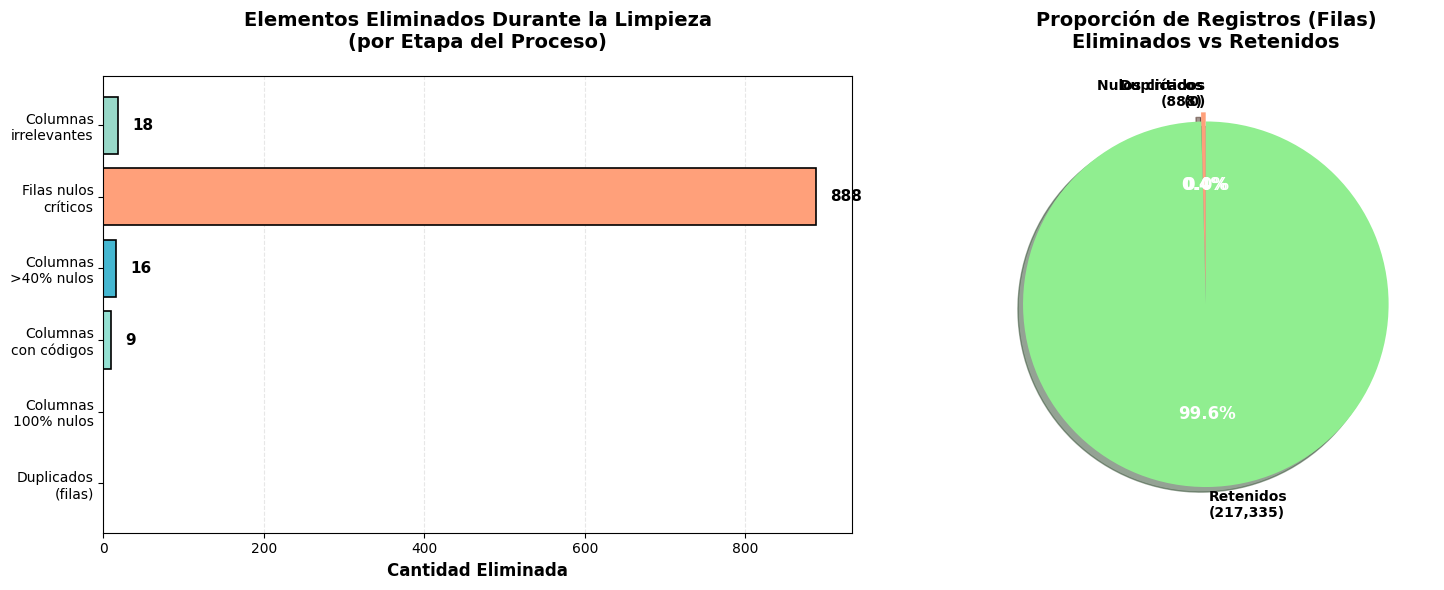


📈 ESTADÍSTICAS DETALLADAS:
   • Tasa de duplicación: 0.00%
   • Tasa de eliminación por nulos: 0.41%
   • Total columnas eliminadas: 43
   • Porcentaje columnas retenidas: 52.22%


In [14]:
# Visualización de métricas de limpieza capturadas
print("="*80)
print(" VISUALIZACIÓN DE REGISTROS ELIMINADOS")
print("="*80)

import matplotlib.pyplot as plt
import numpy as np

# Obtengo métricas de la celda anterior
# Duplicados ya fueron eliminados en la limpieza básica (celda 4)
if DROP_DUPLICATES:
    sdf_sin_duplicados = sdf_saber.dropDuplicates(['periodo', 'estu_consecutivo'])
    duplicados_eliminados = metricas_limpieza['registros_iniciales'] - sdf_sin_duplicados.count()
else:
    duplicados_eliminados = 0

# Columnas 100% nulas (de limpieza básica - celda 4)
columnas_100_nulas = [col for col in sdf_saber.columns 
                      if sdf_saber.filter(F.col(col).isNotNull()).count() == 0]
count_columnas_100_nulas = len(columnas_100_nulas)

# Imprimo resumen
print(f"\n📋 RESUMEN DE LIMPIEZA:")
print(f"   1. Registros iniciales: {metricas_limpieza['registros_iniciales']:,}")
print(f"   2. Columnas iniciales: {metricas_limpieza['columnas_iniciales']}")
print(f"\n   ELIMINACIONES:")
print(f"   • Duplicados: {duplicados_eliminados:,} filas")
print(f"   • Columnas 100% nulos: {count_columnas_100_nulas}")
print(f"   • Columnas con códigos: {metricas_limpieza['columnas_con_codigos']}")
print(f"   • Columnas >40% nulos: {metricas_limpieza['columnas_high_nulls']}")
print(f"   • Filas nulos críticos: {metricas_limpieza['filas_nulos_criticos']:,}")
print(f"   • Columnas irrelevantes: {metricas_limpieza['columnas_irrelevantes']}")
print(f"\n   3. Registros finales: {metricas_limpieza['registros_finales']:,}")
print(f"   4. Columnas finales: {metricas_limpieza['columnas_finales']}")
print(f"\n   📊 Retención: {(metricas_limpieza['registros_finales'] / metricas_limpieza['registros_iniciales'] * 100):.2f}% registros")
print(f"   📊 Columnas eliminadas: {metricas_limpieza['columnas_iniciales'] - metricas_limpieza['columnas_finales']}")

# Preparo datos para visualización
categorias = [
    'Duplicados\n(filas)',
    'Columnas\n100% nulos',
    'Columnas\ncon códigos',
    'Columnas\n>40% nulos',
    'Filas nulos\ncríticos',
    'Columnas\nirrelevantes'
]

valores = [
    duplicados_eliminados,
    count_columnas_100_nulas,
    metricas_limpieza['columnas_con_codigos'],
    metricas_limpieza['columnas_high_nulls'],
    metricas_limpieza['filas_nulos_criticos'],
    metricas_limpieza['columnas_irrelevantes']
]

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Barras horizontales con cantidad eliminada
colors = ['#FF6B6B', '#4ECDC4', '#95E1D3', '#45B7D1', '#FFA07A', '#98D8C8']
bars = ax1.barh(categorias, valores, color=colors, edgecolor='black', linewidth=1.2)

# Etiquetas con valores
for i, (bar, val) in enumerate(zip(bars, valores)):
    if val > 0:
        ax1.text(val + max(valores)*0.02, i, f'{val:,}', 
                 va='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Cantidad Eliminada', fontsize=12, fontweight='bold')
ax1.set_title('Elementos Eliminados Durante la Limpieza\n(por Etapa del Proceso)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Gráfico 2: Pie chart con proporción de registros (filas)
total_filas_eliminadas = duplicados_eliminados + metricas_limpieza['filas_nulos_criticos']
categorias_filas = [
    f'Duplicados\n({duplicados_eliminados:,})',
    f'Nulos críticos\n({metricas_limpieza["filas_nulos_criticos"]:,})',
    f'Retenidos\n({metricas_limpieza["registros_finales"]:,})'
]

valores_filas = [
    duplicados_eliminados,
    metricas_limpieza['filas_nulos_criticos'],
    metricas_limpieza['registros_finales']
]

colors_pie = ['#FF6B6B', '#FFA07A', '#90EE90']
explode = (0.05, 0.05, 0)

wedges, texts, autotexts = ax2.pie(
    valores_filas, 
    labels=categorias_filas,
    autopct='%1.1f%%',
    colors=colors_pie,
    explode=explode,
    shadow=True,
    startangle=90,
    textprops={'fontsize': 10, 'fontweight': 'bold'}
)

# Mejoro legibilidad
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

ax2.set_title('Proporción de Registros (Filas)\nEliminados vs Retenidos', 
              fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Estadísticas finales
print("\n" + "="*80)
print("📈 ESTADÍSTICAS DETALLADAS:")
print(f"   • Tasa de duplicación: {(duplicados_eliminados / metricas_limpieza['registros_iniciales'] * 100):.2f}%")
print(f"   • Tasa de eliminación por nulos: {(metricas_limpieza['filas_nulos_criticos'] / metricas_limpieza['registros_iniciales'] * 100):.2f}%")
print(f"   • Total columnas eliminadas: {metricas_limpieza['columnas_iniciales'] - metricas_limpieza['columnas_finales']}")
print(f"   • Porcentaje columnas retenidas: {(metricas_limpieza['columnas_finales'] / metricas_limpieza['columnas_iniciales'] * 100):.2f}%")
print("="*80)


In [15]:
# Resumen del dataset limpio final
from pyspark.sql import functions as F, Row

print('RESUMEN DEL DATASET LIMPIO FINAL')
print('='*60)

# Selecciono el DataFrame más reciente
if 'sdf_solicitada' in globals():
    df = sdf_solicitada
else:
    df = sdf_saber

# Calculo totales
total_rows = df.count()
col_list = df.columns

print(f'\nEstadísticas generales:')
print(f'   Total de registros: {total_rows:,}')
print(f'   Total de columnas: {len(col_list)}')

# Muestro tabla con tipos de datos de todas las columnas
print(f'\nEstructura del DataFrame (columnas y tipos):')
print(f'{"Columna":<40} {"Tipo":<15}')
print('-' * 56)

for c, t in sorted(df.dtypes):
    print(f'{c:<40} {t:<15}')

RESUMEN DEL DATASET LIMPIO FINAL

Estadísticas generales:
   Total de registros: 217,335
   Total de columnas: 47

Estructura del DataFrame (columnas y tipos):
Columna                                  Tipo           
--------------------------------------------------------
__archivo                                string         
anio                                     int            
cole_area_ubicacion                      string         
cole_bilingue                            string         
cole_calendario                          string         
cole_caracter                            string         
cole_genero                              string         
cole_jornada                             string         
cole_naturaleza                          string         
desemp_ingles                            string         
estu_agregado                            string         
estu_consecutivo                         string         
estu_depto_presentacion                  s

## 3. Exportación del Dataset Limpio

Guardo el dataset limpio en formato CSV para su uso posterior en el notebook de modelado. Utilizo el método Pandas para compatibilidad con Windows.

In [16]:
import os
from pyspark.sql import functions as F

print("="*70)
print("EXPORTACIÓN DEL DATASET LIMPIO")
print("="*70)

# DataFrame final después de todo el proceso de limpieza
df_final_limpio = sdf_solicitada if 'sdf_solicitada' in globals() else sdf_saber

# Definición de ruta de salida
OUTPUT_CSV_PATH = "datos/saber_11_limpio_final.csv"

print(f"\nRuta de salida: {OUTPUT_CSV_PATH}")

# Estadísticas del dataset a exportar
total_registros = df_final_limpio.count()
total_columnas = len(df_final_limpio.columns)

print(f"\nCaracterísticas del dataset limpio:")
print(f"   Total de registros: {total_registros:,}")
print(f"   Total de columnas: {total_columnas}")

# Creación del directorio si no existe
os.makedirs(os.path.dirname(OUTPUT_CSV_PATH), exist_ok=True)

print(f"\nIniciando exportación a CSV...")
print(f"Este proceso puede tomar varios minutos dependiendo del tamaño del dataset...")

# Método de exportación: Conversión a Pandas
# Este método es compatible con Windows y evita dependencias de Hadoop
try:
    print(f"Utilizando método Pandas para exportación...")
    
    # Conversión de Spark DataFrame a Pandas DataFrame
    pdf_final = df_final_limpio.toPandas()
    
    # Exportación del CSV
    pdf_final.to_csv(OUTPUT_CSV_PATH, index=False, encoding='utf-8')
    
    print(f"Exportación completada exitosamente")
    
    # Verificación del archivo generado
    if os.path.exists(OUTPUT_CSV_PATH):
        file_size_mb = os.path.getsize(OUTPUT_CSV_PATH) / (1024 * 1024)
        print(f"Archivo verificado: {file_size_mb:.2f} MB")
    
except MemoryError:
    print("Advertencia: Dataset demasiado grande para conversión directa a Pandas")
    print("Implementando método alternativo de exportación por particiones...")
    
    # Método alternativo: Exportación por particiones
    num_partitions = 10
    output_dir = OUTPUT_CSV_PATH.replace('.csv', '_particiones')
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Dividiendo dataset en {num_partitions} particiones...")
    
    for i in range(num_partitions):
        partition_path = f"{output_dir}/parte_{i+1}.csv"
        df_partition = df_final_limpio.filter(F.rand() < (1.0/num_partitions))
        pdf_partition = df_partition.limit(total_registros // num_partitions).toPandas()
        pdf_partition.to_csv(partition_path, index=False, encoding='utf-8')
        print(f"   Partición {i+1}/{num_partitions} guardada")
    
    print(f"\nDatos exportados en {num_partitions} archivos separados")
    print(f"Ubicación: {output_dir}")
    print(f"Nota: Puede combinar los archivos manualmente si es necesario")

print("\n" + "="*70)
print("PROCESO DE LIMPIEZA Y EXPORTACIÓN COMPLETADO")
print("="*70)
print(f"\nArchivo generado: {OUTPUT_CSV_PATH}")
print(f"Dimensiones: {total_registros:,} registros × {total_columnas} columnas")
print(f"\nEste archivo está listo para utilizarse en el notebook de modelado predictivo")
print(f"Ruta a utilizar: CSV_PATH = '{OUTPUT_CSV_PATH}'")
print("="*70)

EXPORTACIÓN DEL DATASET LIMPIO

Ruta de salida: datos/saber_11_limpio_final.csv

Características del dataset limpio:
   Total de registros: 217,335
   Total de columnas: 47

Iniciando exportación a CSV...
Este proceso puede tomar varios minutos dependiendo del tamaño del dataset...
Utilizando método Pandas para exportación...

Características del dataset limpio:
   Total de registros: 217,335
   Total de columnas: 47

Iniciando exportación a CSV...
Este proceso puede tomar varios minutos dependiendo del tamaño del dataset...
Utilizando método Pandas para exportación...
Exportación completada exitosamente
Archivo verificado: 74.60 MB

PROCESO DE LIMPIEZA Y EXPORTACIÓN COMPLETADO

Archivo generado: datos/saber_11_limpio_final.csv
Dimensiones: 217,335 registros × 47 columnas

Este archivo está listo para utilizarse en el notebook de modelado predictivo
Ruta a utilizar: CSV_PATH = 'datos/saber_11_limpio_final.csv'
Exportación completada exitosamente
Archivo verificado: 74.60 MB

PROCESO DE

## 4. Análisis de Correlaciones entre Variables Numéricas

Realizo un análisis comprehensivo de las correlaciones entre todas las variables numéricas del dataset para identificar relaciones lineales entre variables y detectar posible multicolinealidad.

In [17]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np

print("="*70)
print("ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS")
print("="*70)

# Utilizo el dataset limpio final
df_corr = df_final_limpio if 'df_final_limpio' in globals() else sdf_solicitada

# Identificación de columnas numéricas
numeric_cols = []
for col_name, col_type in df_corr.dtypes:
    if col_type in ('int', 'bigint', 'double', 'float', 'decimal'):
        numeric_cols.append(col_name)

print(f"\nVariables numéricas identificadas: {len(numeric_cols)}")
print(f"\nListado de variables numéricas:")
for i, col in enumerate(numeric_cols, 1):
    print(f"   {i:2d}. {col}")

# Preparación de datos para el cálculo de correlación
print(f"\nPreparando datos para análisis de correlación...")

# Selecciono únicamente columnas numéricas
df_for_corr = df_corr.select(*numeric_cols)

# Conversión explícita a tipo double
for col in numeric_cols:
    df_for_corr = df_for_corr.withColumn(col, F.col(col).cast('double'))

# Eliminación de registros con valores nulos
# La correlación de Pearson requiere datos completos
rows_before = df_for_corr.count()
df_for_corr = df_for_corr.dropna()
rows_after = df_for_corr.count()

print(f"   Registros antes de eliminar nulos: {rows_before:,}")
print(f"   Registros después de eliminar nulos: {rows_after:,}")
print(f"   Registros eliminados: {rows_before - rows_after:,}")

# Ensamblaje de features en un vector
print(f"\nEnsamblando variables en vector de características...")
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
df_vector = assembler.transform(df_for_corr).select('features')

# Cálculo de la matriz de correlación de Pearson
print(f"\nCalculando matriz de correlación (método de Pearson)...")
correlation_matrix = Correlation.corr(df_vector, 'features', 'pearson').collect()[0][0]
corr_array = correlation_matrix.toArray()

# Conversión a DataFrame de Pandas para facilitar análisis
df_corr_pd = pd.DataFrame(
    corr_array,
    columns=numeric_cols,
    index=numeric_cols
)

print(f"\nMatriz de correlación generada exitosamente")
print(f"Dimensiones: {len(numeric_cols)} × {len(numeric_cols)}")

# Extracción de las correlaciones más fuertes
print("\n" + "="*70)
print("TOP 20 CORRELACIONES MÁS FUERTES (excluyendo diagonal)")
print("="*70)

# Extraigo pares únicos de correlaciones (triángulo superior)
correlations_list = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        corr_val = corr_array[i, j]
        correlations_list.append((numeric_cols[i], numeric_cols[j], corr_val))

# Ordeno por valor absoluto de correlación
correlations_sorted = sorted(correlations_list, key=lambda x: abs(x[2]), reverse=True)

print(f"\n{'Variable 1':<30} {'Variable 2':<30} {'Correlación':>12}")
print("-" * 73)
for var1, var2, corr in correlations_sorted[:20]:
    print(f"{var1:<30} {var2:<30} {corr:>12.4f}")

# Exportación de la matriz completa
print("\n" + "="*70)
print("EXPORTACIÓN DE MATRIZ DE CORRELACIÓN")
print("="*70)

output_corr_path = "datos/matriz_correlacion.csv"
df_corr_pd.to_csv(output_corr_path, encoding='utf-8')

print(f"Matriz exportada a: {output_corr_path}")
print(f"Dimensiones: {df_corr_pd.shape[0]} filas × {df_corr_pd.shape[1]} columnas")

# Estadísticas descriptivas de las correlaciones
print("\n" + "="*70)
print("ESTADÍSTICAS DESCRIPTIVAS DE CORRELACIONES")
print("="*70)

# Extraigo valores únicos del triángulo superior (sin diagonal)
upper_triangle = []
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        upper_triangle.append(corr_array[i, j])

upper_triangle = np.array(upper_triangle)

print(f"\nTotal de pares de variables analizados: {len(upper_triangle):,}")
print(f"\nMedidas de tendencia central y dispersión:")
print(f"   Media:                {np.mean(upper_triangle):>8.4f}")
print(f"   Mediana:              {np.median(upper_triangle):>8.4f}")
print(f"   Desviación estándar:  {np.std(upper_triangle):>8.4f}")
print(f"   Valor mínimo:         {np.min(upper_triangle):>8.4f}")
print(f"   Valor máximo:         {np.max(upper_triangle):>8.4f}")

# Clasificación por intensidad de correlación
high_positive = np.sum(upper_triangle > 0.7)
moderate_positive = np.sum((upper_triangle > 0.3) & (upper_triangle <= 0.7))
weak = np.sum((upper_triangle >= -0.3) & (upper_triangle <= 0.3))
moderate_negative = np.sum((upper_triangle < -0.3) & (upper_triangle >= -0.7))
high_negative = np.sum(upper_triangle < -0.7)

print(f"\nDistribución por intensidad de correlación:")
print(f"   Fuerte positiva (> 0.7):       {high_positive:>6} ({high_positive/len(upper_triangle)*100:>5.1f}%)")
print(f"   Moderada positiva (0.3-0.7):   {moderate_positive:>6} ({moderate_positive/len(upper_triangle)*100:>5.1f}%)")
print(f"   Débil (-0.3 a 0.3):            {weak:>6} ({weak/len(upper_triangle)*100:>5.1f}%)")
print(f"   Moderada negativa (-0.7--0.3): {moderate_negative:>6} ({moderate_negative/len(upper_triangle)*100:>5.1f}%)")
print(f"   Fuerte negativa (< -0.7):      {high_negative:>6} ({high_negative/len(upper_triangle)*100:>5.1f}%)")

print("\n" + "="*70)
print("ANÁLISIS DE CORRELACIÓN COMPLETADO")
print("="*70)
print("\nLa matriz completa está disponible en formato CSV para análisis detallado")
print("Puede visualizarse con herramientas como Excel o generarse un heatmap")
print("="*70)

ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES NUMÉRICAS

Variables numéricas identificadas: 8

Listado de variables numéricas:
    1. punt_ingles
    2. punt_matematicas
    3. punt_c_naturales
    4. punt_global
    5. punt_lectura_critica
    6. punt_sociales_ciudadanas
    7. anio
    8. p

Preparando datos para análisis de correlación...
   Registros antes de eliminar nulos: 217,335
   Registros después de eliminar nulos: 217,335
   Registros eliminados: 0

Ensamblando variables en vector de características...

Calculando matriz de correlación (método de Pearson)...

Matriz de correlación generada exitosamente
Dimensiones: 8 × 8

TOP 20 CORRELACIONES MÁS FUERTES (excluyendo diagonal)

Variable 1                     Variable 2                      Correlación
-------------------------------------------------------------------------
punt_c_naturales               punt_global                          0.9293
punt_global                    punt_sociales_ciudadanas             0.9169
punt_mate

## 5. Visualización de Correlaciones Significativas

Genero un heatmap enfocado que muestra únicamente las variables con correlaciones significativas (valor absoluto mayor a 0.3) para facilitar la interpretación visual.

VISUALIZACIÓN DE CORRELACIONES SIGNIFICATIVAS

Umbral de significancia: |r| > 0.3
Variables con correlación significativa identificadas: 6

Generando heatmap de 6 × 6 variables...

Heatmap exportado a: datos/matriz_correlacion_significativas.png

Heatmap exportado a: datos/matriz_correlacion_significativas.png


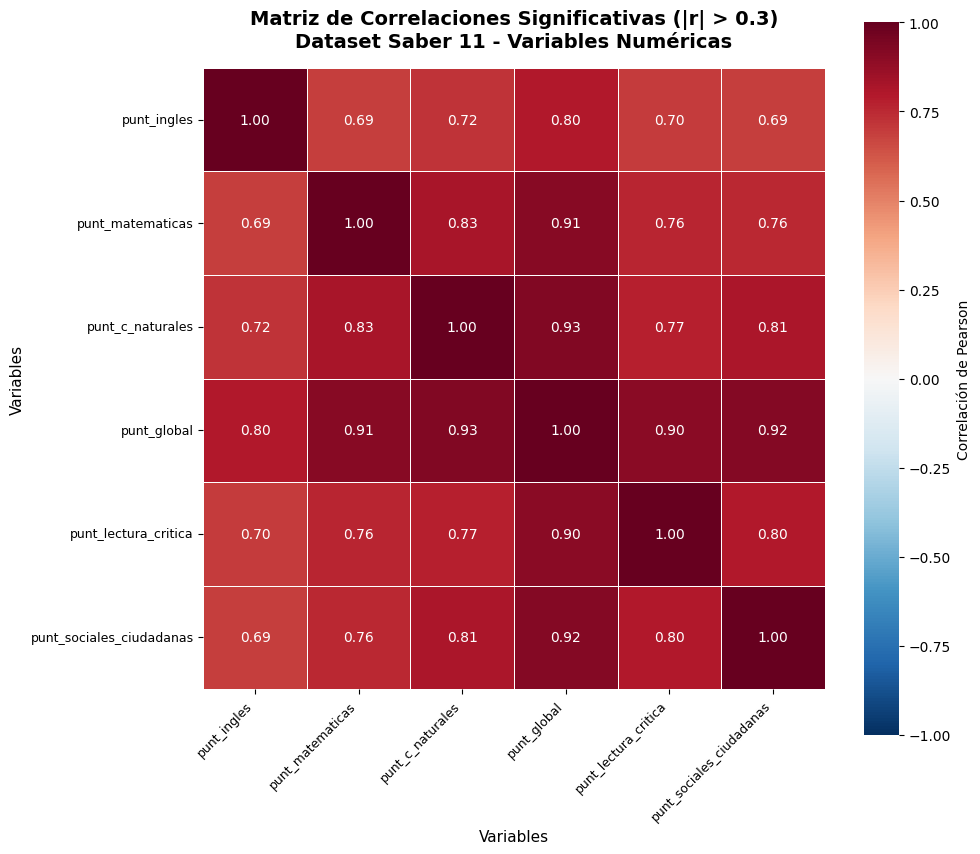


VARIABLES INCLUIDAS EN EL HEATMAP (6):
    1. punt_ingles
    2. punt_matematicas
    3. punt_c_naturales
    4. punt_global
    5. punt_lectura_critica
    6. punt_sociales_ciudadanas

INTERPRETACIÓN DEL HEATMAP:
Colores rojos: Correlaciones positivas (las variables aumentan juntas)
Colores azules: Correlaciones negativas (una aumenta cuando la otra disminuye)
Intensidad del color: Fuerza de la correlación (más intenso = más fuerte)

Esta visualización permite identificar:
   - Variables redundantes que aportan información similar
   - Posibles problemas de multicolinealidad para modelado
   - Relaciones naturales entre variables del dominio educativo


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("="*70)
print("VISUALIZACIÓN DE CORRELACIONES SIGNIFICATIVAS")
print("="*70)

# Verifico que la matriz de correlación esté disponible
if 'df_corr_pd' not in globals():
    print("Error: Debe ejecutar primero la celda de análisis de correlación")
else:
    # Defino el umbral para correlaciones significativas
    THRESHOLD = 0.3
    
    print(f"\nUmbral de significancia: |r| > {THRESHOLD}")
    
    # Identifico variables con al menos una correlación significativa
    strong_vars = []
    corr_matrix = df_corr_pd.values
    
    for i, var in enumerate(df_corr_pd.columns):
        # Analizo correlaciones excluyendo la diagonal (correlación consigo misma = 1.0)
        correlations = corr_matrix[i, :]
        max_corr = np.max(np.abs(correlations[correlations < 0.99999]))
        
        if max_corr > THRESHOLD:
            strong_vars.append(var)
    
    print(f"Variables con correlación significativa identificadas: {len(strong_vars)}")
    
    if len(strong_vars) > 0:
        # Creo submatriz con solo las variables relevantes
        df_corr_subset = df_corr_pd.loc[strong_vars, strong_vars]
        
        # Calculo tamaño óptimo de figura
        n_vars = len(strong_vars)
        fig_size = min(max(10, n_vars * 0.8), 25)
        
        print(f"\nGenerando heatmap de {n_vars} × {n_vars} variables...")
        
        # Creación de la figura
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))
        
        # Generación del heatmap
        sns.heatmap(
            df_corr_subset,
            annot=True if n_vars <= 15 else False,  # Anotaciones solo si hay pocas variables
            fmt='.2f',
            cmap='RdBu_r',  # Esquema de color divergente
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlación de Pearson', 'shrink': 0.8},
            ax=ax
        )
        
        plt.title(f'Matriz de Correlaciones Significativas (|r| > {THRESHOLD})\nDataset Saber 11 - Variables Numéricas', 
                  fontsize=14, fontweight='bold', pad=15)
        plt.xlabel('Variables', fontsize=11)
        plt.ylabel('Variables', fontsize=11)
        
        # Ajuste de etiquetas
        plt.xticks(rotation=45, ha='right', fontsize=9)
        plt.yticks(rotation=0, fontsize=9)
        
        plt.tight_layout()
        
        # Exportación de la visualización
        output_path = "datos/matriz_correlacion_significativas.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"\nHeatmap exportado a: {output_path}")
        
        plt.show()
        
        # Listado de variables incluidas en la visualización
        print("\n" + "="*70)
        print(f"VARIABLES INCLUIDAS EN EL HEATMAP ({len(strong_vars)}):")
        print("="*70)
        for i, var in enumerate(strong_vars, 1):
            print(f"   {i:2d}. {var}")
        
        print("\n" + "="*70)
        print("INTERPRETACIÓN DEL HEATMAP:")
        print("="*70)
        print("Colores rojos: Correlaciones positivas (las variables aumentan juntas)")
        print("Colores azules: Correlaciones negativas (una aumenta cuando la otra disminuye)")
        print("Intensidad del color: Fuerza de la correlación (más intenso = más fuerte)")
        print("\nEsta visualización permite identificar:")
        print("   - Variables redundantes que aportan información similar")
        print("   - Posibles problemas de multicolinealidad para modelado")
        print("   - Relaciones naturales entre variables del dominio educativo")
        print("="*70)
    else:
        print(f"\nNo se encontraron variables con correlación superior a {THRESHOLD}")

## 6. Inventario Final de Variables por Categoría

Esta sección presenta un inventario completo y organizado de todas las variables que permanecen en el dataset después del proceso de limpieza, clasificadas por categorías temáticas para facilitar su comprensión y uso en el modelado predictivo.

In [19]:
from collections import defaultdict

print("="*80)
print("INVENTARIO COMPLETO DE VARIABLES POR CATEGORÍA TEMÁTICA")
print("="*80)

# Utilizo el dataset limpio final
df_inventario = df_final_limpio if 'df_final_limpio' in globals() else sdf_solicitada

# Obtengo todas las columnas con sus tipos
columnas_con_tipos = df_inventario.dtypes

print(f"\nTotal de variables en el dataset limpio: {len(columnas_con_tipos)}\n")

# Diccionario de clasificación manual por variable específica
clasificacion_manual = {
    # 1. Identificación y Contexto
    'estu_consecutivo': '1. Identificación y Contexto',
    'estu_estudiante': '1. Identificación y Contexto',
    'periodo': '1. Identificación y Contexto',
    'anio': '1. Identificación y Contexto',
    'p': '1. Identificación y Contexto',
    'municipio': '1. Identificación y Contexto',
    '__archivo': '1. Identificación y Contexto',
    
    # 2. Características Demográficas del Estudiante
    'estu_genero': '2. Características Demográficas del Estudiante',
    'estu_fechanacimiento': '2. Características Demográficas del Estudiante',
    'estu_nacionalidad': '2. Características Demográficas del Estudiante',
    'estu_tipodocumento': '2. Características Demográficas del Estudiante',
    'estu_tieneetnia': '2. Características Demográficas del Estudiante',
    
    # 3. Ubicación Geográfica del Estudiante
    'estu_pais_reside': '3. Ubicación Geográfica del Estudiante',
    'estu_depto_reside': '3. Ubicación Geográfica del Estudiante',
    'estu_mcpio_reside': '3. Ubicación Geográfica del Estudiante',
    'estu_depto_presentacion': '3. Ubicación Geográfica del Estudiante',
    'estu_mcpio_presentacion': '3. Ubicación Geográfica del Estudiante',
    
    # 4. Condición Educativa del Estudiante
    'estu_grado': '4. Condición Educativa del Estudiante',
    'estu_repite': '4. Condición Educativa del Estudiante',
    'estu_agregado': '4. Condición Educativa del Estudiante',
    
    # 5. Condición Social del Estudiante
    'estu_privado_libertad': '5. Condición Social del Estudiante',
    'estu_discapacidad': '5. Condición Social del Estudiante',
    
    # 6. Composición Familiar
    'fami_personashogar': '6. Composición Familiar',
    'fami_cuartoshogar': '6. Composición Familiar',
    
    # 7. Nivel Educativo Familiar
    'fami_educacionpadre': '7. Nivel Educativo Familiar',
    'fami_educacionmadre': '7. Nivel Educativo Familiar',
    
    # 8. Condiciones Socioeconómicas del Hogar
    'fami_estratovivienda': '8. Condiciones Socioeconómicas del Hogar',
    'fami_tieneautomovil': '8. Condiciones Socioeconómicas del Hogar',
    'fami_tienelavadora': '8. Condiciones Socioeconómicas del Hogar',
    'fami_tieneserviciotv': '8. Condiciones Socioeconómicas del Hogar',
    
    # 9. Acceso a Recursos Educativos en el Hogar
    'fami_tienecomputador': '9. Acceso a Recursos Educativos en el Hogar',
    'fami_tieneinternet': '9. Acceso a Recursos Educativos en el Hogar',
    'fami_numlibros': '9. Acceso a Recursos Educativos en el Hogar',
    
    # 10. Características del Establecimiento Educativo
    'cole_naturaleza': '10. Características del Establecimiento Educativo',
    'cole_calendario': '10. Características del Establecimiento Educativo',
    'cole_bilingue': '10. Características del Establecimiento Educativo',
    'cole_caracter': '10. Características del Establecimiento Educativo',
    'cole_genero': '10. Características del Establecimiento Educativo',
    'cole_jornada': '10. Características del Establecimiento Educativo',
    'cole_area_ubicacion': '10. Características del Establecimiento Educativo',
    
    # 11. Resultados en Áreas de Conocimiento
    'punt_global': '11. Resultados en Áreas de Conocimiento',
    'punt_lectura_critica': '11. Resultados en Áreas de Conocimiento',
    'punt_matematicas': '11. Resultados en Áreas de Conocimiento',
    'punt_c_naturales': '11. Resultados en Áreas de Conocimiento',
    'punt_sociales_ciudadanas': '11. Resultados en Áreas de Conocimiento',
    'punt_ingles': '11. Resultados en Áreas de Conocimiento',
    'desemp_ingles': '11. Resultados en Áreas de Conocimiento'
}

# Definición de categorías con descripciones detalladas
categorias = {
    "1. Identificación y Contexto": {
        "descripcion": "Variables de identificación única y contexto temporal/geográfico del examen"
    },
    "2. Características Demográficas del Estudiante": {
        "descripcion": "Información demográfica básica del estudiante (género, edad, nacionalidad, etnia)"
    },
    "3. Ubicación Geográfica del Estudiante": {
        "descripcion": "Información sobre el lugar de residencia y presentación del examen"
    },
    "4. Condición Educativa del Estudiante": {
        "descripcion": "Variables relacionadas con la trayectoria académica del estudiante"
    },
    "5. Condición Social del Estudiante": {
        "descripcion": "Condiciones especiales o situaciones sociales del estudiante"
    },
    "6. Composición Familiar": {
        "descripcion": "Estructura y tamaño del núcleo familiar"
    },
    "7. Nivel Educativo Familiar": {
        "descripcion": "Nivel de educación alcanzado por los padres"
    },
    "8. Condiciones Socioeconómicas del Hogar": {
        "descripcion": "Indicadores económicos y materiales del hogar"
    },
    "9. Acceso a Recursos Educativos en el Hogar": {
        "descripcion": "Disponibilidad de recursos tecnológicos y educativos en casa"
    },
    "10. Características del Establecimiento Educativo": {
        "descripcion": "Características institucionales del colegio"
    },
    "11. Resultados en Áreas de Conocimiento": {
        "descripcion": "Puntajes obtenidos en las diferentes áreas evaluadas"
    }
}

# Clasificación de variables por categoría usando el diccionario manual
variables_por_categoria = defaultdict(list)

for col_name, col_type in columnas_con_tipos:
    categoria = clasificacion_manual.get(col_name, "12. No Clasificadas")
    variables_por_categoria[categoria].append((col_name, col_type))

# Presentación del inventario por categorías
for categoria in sorted(categorias.keys()):
    variables = variables_por_categoria.get(categoria, [])
    
    print("=" * 80)
    print(f"{categoria}")
    print("-" * 80)
    print(f"Descripción: {categorias[categoria]['descripcion']}")
    print(f"Total de variables: {len(variables)}")
    print("-" * 80)
    
    if variables:
        # Separación por tipo de dato
        numericas = [(v, t) for v, t in variables if t in ('int', 'bigint', 'double', 'float', 'decimal')]
        categoricas = [(v, t) for v, t in variables if t == 'string']
        
        if numericas:
            print(f"\n   Variables Numéricas ({len(numericas)}):")
            for i, (var, tipo) in enumerate(sorted(numericas), 1):
                print(f"      {i:2d}. {var:<45} ({tipo})")
        
        if categoricas:
            print(f"\n   Variables Categóricas ({len(categoricas)}):")
            for i, (var, tipo) in enumerate(sorted(categoricas), 1):
                print(f"      {i:2d}. {var:<45} ({tipo})")
    else:
        print("\n   (No hay variables en esta categoría)")
    
    print()

# Variables no clasificadas
if "12. No Clasificadas" in variables_por_categoria:
    print("=" * 80)
    print("12. Variables No Clasificadas")
    print("-" * 80)
    print(f"Total: {len(variables_por_categoria['12. No Clasificadas'])}")
    print("-" * 80)
    for var, tipo in variables_por_categoria["12. No Clasificadas"]:
        print(f"   - {var:<45} ({tipo})")
    print()

# Resumen estadístico por tipo de dato
print("=" * 80)
print("RESUMEN POR TIPO DE DATO")
print("=" * 80)

tipos_conteo = defaultdict(int)
for _, tipo in columnas_con_tipos:
    tipos_conteo[tipo] += 1

print(f"\n{'Tipo de Dato':<20} {'Cantidad':>10} {'Porcentaje':>12}")
print("-" * 44)
total = len(columnas_con_tipos)
for tipo, cantidad in sorted(tipos_conteo.items(), key=lambda x: x[1], reverse=True):
    porcentaje = (cantidad / total) * 100
    print(f"{tipo:<20} {cantidad:>10} {porcentaje:>11.1f}%")

print(f"\n{'TOTAL':<20} {total:>10} {100.0:>11.1f}%")

# Resumen final con agrupación lógica
print("\n" + "=" * 80)
print("RESUMEN FINAL POR GRUPO TEMÁTICO")
print("=" * 80)
print(f"\nRegistros totales: {df_inventario.count():,}")
print(f"Variables totales: {len(columnas_con_tipos)}")

# Agrupación de categorías relacionadas
grupos_tematicos = {
    "INFORMACIÓN CONTEXTUAL": ["1. Identificación y Contexto"],
    "PERFIL DEL ESTUDIANTE": [
        "2. Características Demográficas del Estudiante",
        "3. Ubicación Geográfica del Estudiante",
        "4. Condición Educativa del Estudiante",
        "5. Condición Social del Estudiante"
    ],
    "CONTEXTO FAMILIAR": [
        "6. Composición Familiar",
        "7. Nivel Educativo Familiar",
        "8. Condiciones Socioeconómicas del Hogar",
        "9. Acceso a Recursos Educativos en el Hogar"
    ],
    "CONTEXTO INSTITUCIONAL": [
        "10. Características del Establecimiento Educativo"
    ],
    "RESULTADOS ACADÉMICOS": [
        "11. Resultados en Áreas de Conocimiento"
    ]
}

print("\n" + "-" * 80)
for grupo, categorias_grupo in grupos_tematicos.items():
    total_vars_grupo = sum(len(variables_por_categoria.get(cat, [])) for cat in categorias_grupo)
    print(f"\n{grupo}: {total_vars_grupo} variables")
    for cat in categorias_grupo:
        num_vars = len(variables_por_categoria.get(cat, []))
        print(f"   • {cat.split('. ')[1]}: {num_vars}")

print("\n" + "=" * 80)
print("El dataset está listo para ser utilizado en el notebook de modelado predictivo")
print("=" * 80)

INVENTARIO COMPLETO DE VARIABLES POR CATEGORÍA TEMÁTICA

Total de variables en el dataset limpio: 47

1. Identificación y Contexto
--------------------------------------------------------------------------------
Descripción: Variables de identificación única y contexto temporal/geográfico del examen
Total de variables: 7
--------------------------------------------------------------------------------

   Variables Numéricas (2):
       1. anio                                          (int)
       2. p                                             (int)

   Variables Categóricas (5):
       1. __archivo                                     (string)
       2. estu_consecutivo                              (string)
       3. estu_estudiante                               (string)
       4. municipio                                     (string)
       5. periodo                                       (string)

10. Características del Establecimiento Educativo
------------------------------------

## 7. Diccionario de Variables del Dataset

Se genera un diccionario estructurado con todas las variables clasificadas por categorías temáticas para facilitar su consulta y uso programático en análisis posteriores.

In [20]:
print("="*80)
print("DICCIONARIO DE VARIABLES DEL DATASET SABER 11")
print("="*80)

# Diccionario completo con todas las variables clasificadas por categorías
diccionario_variables = {
    "1. Identificación y Contexto": {
        "descripcion": "Variables de identificación única y contexto temporal/geográfico del examen",
        "numericas": [
            "anio",
            "p"
        ],
        "categoricas": [
            "__archivo",
            "estu_consecutivo",
            "estu_estudiante",
            "municipio",
            "periodo"
        ]
    },
    
    "2. Características Demográficas del Estudiante": {
        "descripcion": "Información demográfica básica del estudiante (género, edad, nacionalidad, etnia)",
        "numericas": [],
        "categoricas": [
            "estu_fechanacimiento",
            "estu_genero",
            "estu_nacionalidad",
            "estu_tieneetnia",
            "estu_tipodocumento"
        ]
    },
    
    "3. Ubicación Geográfica del Estudiante": {
        "descripcion": "Información sobre el lugar de residencia y presentación del examen",
        "numericas": [],
        "categoricas": [
            "estu_depto_presentacion",
            "estu_depto_reside",
            "estu_mcpio_presentacion",
            "estu_mcpio_reside",
            "estu_pais_reside"
        ]
    },
    
    "4. Condición Educativa del Estudiante": {
        "descripcion": "Variables relacionadas con la trayectoria académica del estudiante",
        "numericas": [],
        "categoricas": [
            "estu_agregado",
            "estu_grado",
            "estu_repite"
        ]
    },
    
    "5. Condición Social del Estudiante": {
        "descripcion": "Condiciones especiales o situaciones sociales del estudiante",
        "numericas": [],
        "categoricas": [
            "estu_discapacidad",
            "estu_privado_libertad"
        ]
    },
    
    "6. Composición Familiar": {
        "descripcion": "Estructura y tamaño del núcleo familiar",
        "numericas": [],
        "categoricas": [
            "fami_cuartoshogar",
            "fami_personashogar"
        ]
    },
    
    "7. Nivel Educativo Familiar": {
        "descripcion": "Nivel de educación alcanzado por los padres",
        "numericas": [],
        "categoricas": [
            "fami_educacionmadre",
            "fami_educacionpadre"
        ]
    },
    
    "8. Condiciones Socioeconómicas del Hogar": {
        "descripcion": "Indicadores económicos y materiales del hogar",
        "numericas": [],
        "categoricas": [
            "fami_estratovivienda",
            "fami_tieneautomovil",
            "fami_tienelavadora",
            "fami_tieneserviciotv"
        ]
    },
    
    "9. Acceso a Recursos Educativos en el Hogar": {
        "descripcion": "Disponibilidad de recursos tecnológicos y educativos en casa",
        "numericas": [],
        "categoricas": [
            "fami_numlibros",
            "fami_tienecomputador",
            "fami_tieneinternet"
        ]
    },
    
    "10. Características del Establecimiento Educativo": {
        "descripcion": "Características institucionales del colegio",
        "numericas": [],
        "categoricas": [
            "cole_area_ubicacion",
            "cole_bilingue",
            "cole_calendario",
            "cole_caracter",
            "cole_genero",
            "cole_jornada",
            "cole_naturaleza"
        ]
    },
    
    "11. Resultados en Áreas de Conocimiento": {
        "descripcion": "Puntajes obtenidos en las diferentes áreas evaluadas",
        "numericas": [
            "punt_c_naturales",
            "punt_global",
            "punt_ingles",
            "punt_lectura_critica",
            "punt_matematicas",
            "punt_sociales_ciudadanas"
        ],
        "categoricas": [
            "desemp_ingles"
        ]
    }
}

# Presentación del diccionario
print("\nDiccionario creado exitosamente con 11 categorías temáticas\n")
print("="*80)

# Resumen cuantitativo
total_vars = 0
total_numericas = 0
total_categoricas = 0

for categoria, datos in diccionario_variables.items():
    num_numericas = len(datos['numericas'])
    num_categoricas = len(datos['categoricas'])
    total_categoria = num_numericas + num_categoricas
    
    total_vars += total_categoria
    total_numericas += num_numericas
    total_categoricas += num_categoricas
    
    print(f"\n{categoria}")
    print("-" * 80)
    print(f"Descripción: {datos['descripcion']}")
    print(f"Variables: {total_categoria} (Numéricas: {num_numericas}, Categóricas: {num_categoricas})")

print("\n" + "="*80)
print("RESUMEN TOTAL")
print("="*80)
print(f"Total de variables: {total_vars}")
print(f"Variables numéricas: {total_numericas} ({total_numericas/total_vars*100:.1f}%)")
print(f"Variables categóricas: {total_categoricas} ({total_categoricas/total_vars*100:.1f}%)")
print("="*80)

# Ejemplo de uso del diccionario
print("\n" + "="*80)
print("EJEMPLOS DE USO DEL DICCIONARIO")
print("="*80)

print("\n1. Obtener todas las variables numéricas del dataset:")
print("-" * 80)
todas_numericas = []
for categoria, datos in diccionario_variables.items():
    todas_numericas.extend(datos['numericas'])
print(f"Variables numéricas: {todas_numericas}")

print("\n2. Obtener variables de resultados académicos:")
print("-" * 80)
resultado_vars = diccionario_variables["11. Resultados en Áreas de Conocimiento"]
print(f"Descripción: {resultado_vars['descripcion']}")
print(f"Variables numéricas: {resultado_vars['numericas']}")
print(f"Variables categóricas: {resultado_vars['categoricas']}")

print("\n3. Obtener todas las variables relacionadas con el contexto familiar:")
print("-" * 80)
categorias_familiares = [
    "6. Composición Familiar",
    "7. Nivel Educativo Familiar",
    "8. Condiciones Socioeconómicas del Hogar",
    "9. Acceso a Recursos Educativos en el Hogar"
]
vars_familiares = []
for cat in categorias_familiares:
    vars_familiares.extend(diccionario_variables[cat]['numericas'])
    vars_familiares.extend(diccionario_variables[cat]['categoricas'])
print(f"Total de variables del contexto familiar: {len(vars_familiares)}")
print(f"Variables: {vars_familiares}")

print("\n" + "="*80)
print("El diccionario está disponible en la variable: diccionario_variables")
print("="*80)

DICCIONARIO DE VARIABLES DEL DATASET SABER 11

Diccionario creado exitosamente con 11 categorías temáticas


1. Identificación y Contexto
--------------------------------------------------------------------------------
Descripción: Variables de identificación única y contexto temporal/geográfico del examen
Variables: 7 (Numéricas: 2, Categóricas: 5)

2. Características Demográficas del Estudiante
--------------------------------------------------------------------------------
Descripción: Información demográfica básica del estudiante (género, edad, nacionalidad, etnia)
Variables: 5 (Numéricas: 0, Categóricas: 5)

3. Ubicación Geográfica del Estudiante
--------------------------------------------------------------------------------
Descripción: Información sobre el lugar de residencia y presentación del examen
Variables: 5 (Numéricas: 0, Categóricas: 5)

4. Condición Educativa del Estudiante
--------------------------------------------------------------------------------
Descripción: Va

## Tabla Resumen: 11 Categorías y Variables del Dataset

Tabla consolidada que muestra todas las categorías temáticas con sus variables clasificadas por tipo (numérica o categórica).

In [21]:
import pandas as pd

# Creo una tabla consolidada con todas las categorías y variables
tabla_data = []

for categoria, datos in diccionario_variables.items():
    # Variables numéricas
    for var in datos['numericas']:
        tabla_data.append({
            'Categoría': categoria,
            'Descripción Categoría': datos['descripcion'],
            'Variable': var,
            'Tipo': 'Numérica'
        })
    
    # Variables categóricas
    for var in datos['categoricas']:
        tabla_data.append({
            'Categoría': categoria,
            'Descripción Categoría': datos['descripcion'],
            'Variable': var,
            'Tipo': 'Categórica'
        })

# Creo el DataFrame
df_variables = pd.DataFrame(tabla_data)

# Muestro estadísticas generales
print("="*100)
print(" TABLA COMPLETA: 11 CATEGORÍAS Y TODAS LAS VARIABLES DEL DATASET SABER 11")
print("="*100)
print(f"\n📊 Total de variables: {len(df_variables)}")
print(f"📊 Variables numéricas: {len(df_variables[df_variables['Tipo']=='Numérica'])} ({len(df_variables[df_variables['Tipo']=='Numérica'])/len(df_variables)*100:.1f}%)")
print(f"📊 Variables categóricas: {len(df_variables[df_variables['Tipo']=='Categórica'])} ({len(df_variables[df_variables['Tipo']=='Categórica'])/len(df_variables)*100:.1f}%)")
print(f"📊 Número de categorías: 11\n")

# Muestro resumen por categoría
print("="*100)
print(" RESUMEN POR CATEGORÍA")
print("="*100)
resumen_categorias = df_variables.groupby(['Categoría', 'Tipo']).size().unstack(fill_value=0)
resumen_categorias['Total'] = resumen_categorias.sum(axis=1)
print(resumen_categorias.to_string())

# Muestro la tabla completa
print("\n" + "="*100)
print(" TABLA DETALLADA: TODAS LAS VARIABLES POR CATEGORÍA")
print("="*100)

# Configuro pandas para mostrar todas las filas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.width', None)

# Muestro la tabla completa ordenada por categoría
print(df_variables.to_string(index=False))

# Reseteo opciones
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')
pd.reset_option('display.width')

# Guardo como CSV para referencia (opcional)
print("\n" + "="*100)
print("💾 Guardando tabla en formato CSV...")
csv_path = 'datos/diccionario_variables_completo.csv'
df_variables.to_csv(csv_path, index=False, encoding='utf-8-sig')
print(f"✅ Tabla guardada en: {csv_path}")
print("="*100)

# Muestro ejemplos de uso
print("\n" + "="*100)
print(" EJEMPLOS DE CONSULTA")
print("="*100)

print("\n1️⃣ Variables de la Categoría '11. Resultados en Áreas de Conocimiento':")
print("-" * 100)
resultado_vars = df_variables[df_variables['Categoría'] == '11. Resultados en Áreas de Conocimiento']
print(resultado_vars[['Variable', 'Tipo']].to_string(index=False))

print("\n2️⃣ Todas las variables numéricas del dataset:")
print("-" * 100)
numericas = df_variables[df_variables['Tipo'] == 'Numérica']['Variable'].tolist()
print(f"Total: {len(numericas)} variables")
print(numericas)

print("\n3️⃣ Variables relacionadas con el contexto familiar (categorías 6-9):")
print("-" * 100)
categorias_fam = ['6. Composición Familiar', '7. Nivel Educativo Familiar', 
                   '8. Condiciones Socioeconómicas del Hogar', '9. Acceso a Recursos Educativos en el Hogar']
vars_fam = df_variables[df_variables['Categoría'].isin(categorias_fam)]
print(f"Total: {len(vars_fam)} variables")
print(vars_fam[['Categoría', 'Variable', 'Tipo']].to_string(index=False))

print("\n" + "="*100)
print("✅ DataFrame disponible en la variable: df_variables")
print("="*100)


 TABLA COMPLETA: 11 CATEGORÍAS Y TODAS LAS VARIABLES DEL DATASET SABER 11

📊 Total de variables: 47
📊 Variables numéricas: 8 (17.0%)
📊 Variables categóricas: 39 (83.0%)
📊 Número de categorías: 11

 RESUMEN POR CATEGORÍA
Tipo                                               Categórica  Numérica  Total
Categoría                                                                     
1. Identificación y Contexto                                5         2      7
10. Características del Establecimiento Educativo           7         0      7
11. Resultados en Áreas de Conocimiento                     1         6      7
2. Características Demográficas del Estudiante              5         0      5
3. Ubicación Geográfica del Estudiante                      5         0      5
4. Condición Educativa del Estudiante                       3         0      3
5. Condición Social del Estudiante                          2         0      2
6. Composición Familiar                                     2        